# Final setup: XGBoost
Packages:

In [83]:
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score, train_test_split, RandomizedSearchCV, KFold, StratifiedKFold
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.datasets import make_friedman1
from sklearn.model_selection import StratifiedKFold
from sklearn.utils import shuffle
import json
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import warnings
warnings.filterwarnings('ignore')
from utils import FriedmanDataset, run_kfold_visualizer, ModelOptimizerFinal 


Create json file to save all experiments reulst and hyperparameters:

In [2]:
json_file = "./results-xgb-nadja.json" # set path to save json-file 

'''
from datetime import date
today = date.today().strftime("%d-%m-%Y")
today

json_file = "./results-xgb-boxplot1-" + today + ".json" # set path to save json-file 


#create json file with empy list with path json_file 
with open(json_file, 'w') as f:
    json.dump([], f)
'''


'\nfrom datetime import date\ntoday = date.today().strftime("%d-%m-%Y")\ntoday\n\njson_file = "./results-xgb-boxplot1-" + today + ".json" # set path to save json-file \n\n\n#create json file with empy list with path json_file \nwith open(json_file, \'w\') as f:\n    json.dump([], f)\n'

Define hyperparameters:

In [76]:
# Data Creation
n_train= 1000
n_test= 100000
n_features = 10
FD_noise= 2
transformation='identity'
seed=100
np.random.seed(seed) # for selecting hyperparameters grid

# Stratification
n_groups = 10

# RandomSearchCV
n_folds = 5
n_iter= 200
n_repetitions=20
scoring= 'neg_mean_squared_error' 
n_jobs= -1

param_grid = {
    'learning_rate': np.linspace(0.001, 0.4, num =10), #default 0.3
    'max_depth':  [int(i) for i in np.logspace(np.log10(2), np.log10(20), num =20) ], # defualt 6
    'subsample': [np.random.uniform(0.5,1) for i in range(10)], # default 1
    'colsample_bytree': [np.random.uniform(0.5,1) for i in range(10)],# default 1
    'gamma': np.logspace(0, np.log10(20), num =10), #default 0
    'min_child_weight': np.arange(1, 10) #default 1
}
#'n_estimators': np.arange(100, 1000), #don't find it in parameters online (I think it depends on xgbosst version)
#'learning_rate': np.logspace(np.log10(0.001), np.log10(0.6), num =10), #default 0.3

# Initalize Model
modelOptimizer = ModelOptimizerFinal(xgb.XGBRegressor(random_state=seed), 
                                param_grid,
                                random_state=seed)

# Save Parameters in a dictionary
params = {'model': modelOptimizer.model.__class__.__name__,
          'n_train': n_train,
          'n_test': n_test,
          'n_features': n_features,
          'FD_noise': FD_noise,
          'transformation': transformation,
          'n_groups': n_groups,
          'n_folds': n_folds,
          'n_iter': n_iter,
          'n_repetitions': n_repetitions,
          'scoring': scoring, 
          'n_jobs': n_jobs,
          'json_file': json_file}
params

{'model': 'XGBRegressor',
 'n_train': 1000,
 'n_test': 100000,
 'n_features': 10,
 'FD_noise': 2,
 'transformation': 'identity',
 'n_groups': 10,
 'n_folds': 5,
 'n_iter': 200,
 'n_repetitions': 20,
 'scoring': 'neg_mean_squared_error',
 'n_jobs': -1,
 'json_file': './results-xgb-nadja.json'}

In [64]:
# iterate over param_grid.keys() and print lenth
combinations = 1
for key in param_grid.keys():
    count  = len(param_grid[key])
    print(key, count)
    combinations *= count
print('combinations', combinations)

learning_rate 10
max_depth 10
subsample 10
colsample_bytree 10
gamma 10
min_child_weight 9
combinations 900000


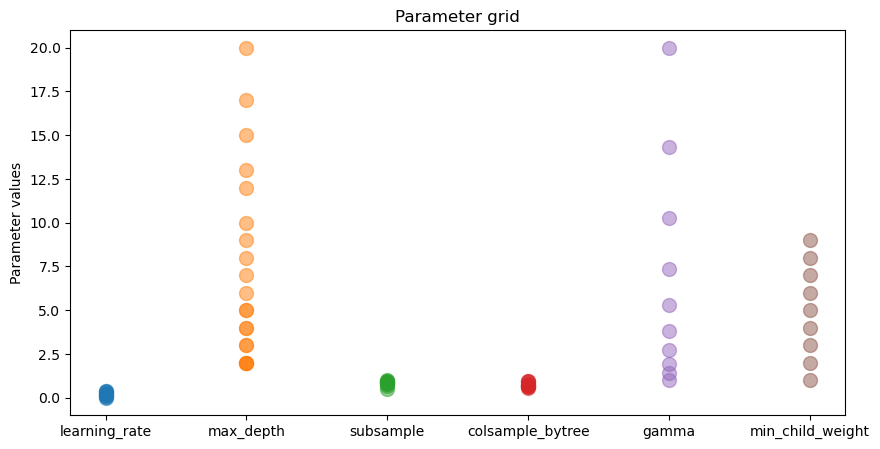

In [77]:
# plot param_grid: each parameter on y, number of values on x, points
fig, ax = plt.subplots(figsize=(10, 5))
for i, key in enumerate(param_grid.keys()):
    count  = len(param_grid[key])
    ax.scatter(np.repeat(i, count), param_grid[key], s=100, alpha=0.5)
    ax.set_xticks(range(len(param_grid.keys())))
    ax.set_xticklabels(param_grid.keys())
    ax.set_ylabel('Parameter values')
    ax.set_title('Parameter grid')
plt.show()


6


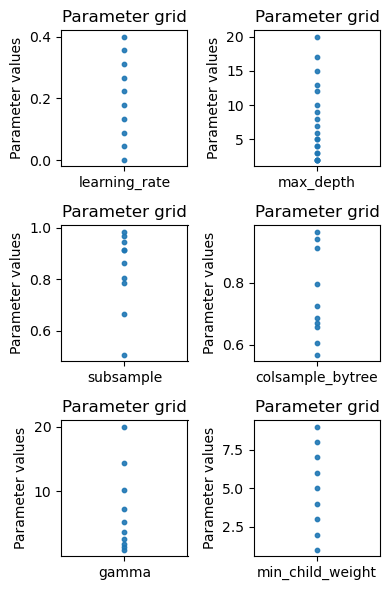

In [82]:
# Plot each parameter in separate plots
print(len(param_grid))
fig, axes = plt.subplots(3, 2, figsize=(4, 6))
axes = axes.flatten()

for i, key in enumerate(param_grid.keys()):
    count = len(param_grid[key])
    ax = axes[i]
    ax.scatter(np.repeat(i, count), param_grid[key], s=10, alpha=0.9)
    ax.set_xticks([i])
    ax.set_xticklabels([key])
    ax.set_ylabel('Parameter values')
    ax.set_title('Parameter grid')

plt.tight_layout()

# Save the figure
fig.savefig('./plots/XGBBoost_parameter_plots.png')
plt.show()


In [32]:
param_grid['learning_rate']


array([1.00230524, 1.08198745, 1.16800431, 1.26085942, 1.36109641,
       1.46930214, 1.58611011, 1.71220419, 1.84832262, 1.99526231])

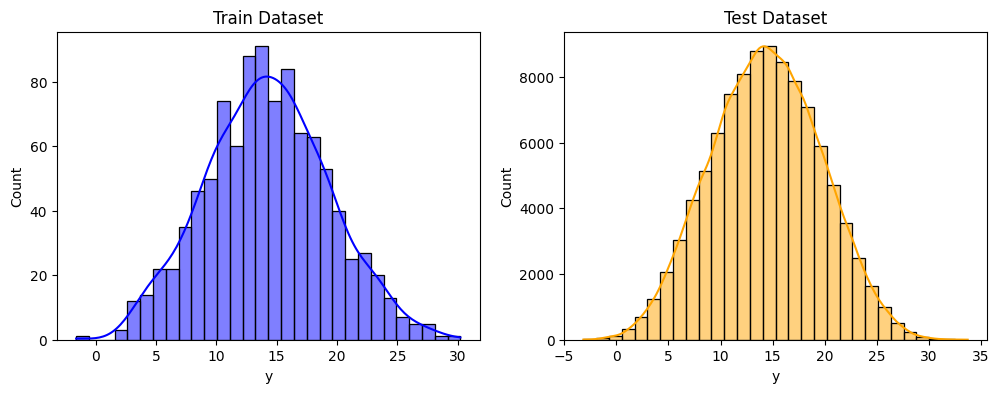

In [4]:
train = FriedmanDataset(n_samples=n_train, 
                            n_features=n_features, 
                            noise=FD_noise, 
                            random_state=42)
train.transform(transformation=transformation)

test = FriedmanDataset(n_samples=n_test,
                           n_features=n_features,
                           noise=FD_noise,
                           random_state=1718)
test.transform(transformation=transformation)


# Show here histograms of train and train datasets
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

sns.histplot(train.df, x='y', bins=30, kde=True, ax=axes[0], color='blue')
axes[0].set_title('Train Dataset')

sns.histplot(test.df, x='y', bins=30, kde=True, ax=axes[1], color='orange')
axes[1].set_title('Test Dataset')

plt.show()

In [5]:
unstratified_results, stratified_results = modelOptimizer.optimize(params)

RandomizesdSearchCV with params n_folds = 5 , ngroups:  10 , scoring:  neg_mean_squared_error , n_jobs:  -1 , n_iter:  200  and save to   ./results-xgb-nadja.json 

Best Parameters: {'subsample': 0.7546457661607673, 'n_estimators': 550, 'min_child_weight': 7, 'max_depth': 4, 'learning_rate': 0.06252118425366, 'gamma': nan, 'colsample_bytree': 0.7609483229681392}
Evaluation Results of Random Split Cross-validation :  {'train r2': 0.9876, 'test r2': 0.806, 'train mse': 0.3476, 'test mse': 5.3965, 'train mae': 0.4445, 'test mae': 1.8505}
running_time:  6.61  min
Best Parameters: {'subsample': 0.5921785529683752, 'n_estimators': 749, 'min_child_weight': 6, 'max_depth': 4, 'learning_rate': 0.06252118425366, 'gamma': nan, 'colsample_bytree': 0.528203710906934}
Evaluation Results of Stratified Split Cross-validation :  {'train r2': 0.9917, 'test r2': 0.7996, 'train mse': 0.2334, 'test mse': 5.5722, 'train mae': 0.3687, 'test mae': 1.8823}
running_time:  7.09  min
Best Parameters: {'subsample'